## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

zsh:1: command not found: wget
unzip:  cannot find or open ml-1m.zip, ml-1m.zip.zip or ml-1m.zip.ZIP.
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

In [9]:
df_train['user_id'].nunique()

5365

In [10]:
df_test['user_id'].nunique()

1147

In [11]:
users = df['user_id'].unique()
items = df['item_id'].unique()

user_map = {user: i for i, user in enumerate(users)}
item_map = {item: i for i, item in enumerate(items)}

matrix = np.zeros((len(users), len(items)))

for _, row in df.iterrows():
    matrix[user_map[row['user_id']], item_map[row['item_id']]] = row['rating']

In [12]:
matrix

array([[5., 3., 3., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]])

In [13]:
matrix.shape

(6040, 3011)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [14]:
import pandas as pd
import numpy as np

def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    
    users = df['user_id'].astype('category').cat.codes
    items = df['item_id'].astype('category').cat.codes
    
    matrix = np.zeros((users.max() + 1, items.max() + 1))
    matrix[users, items] = df['rating'].values
    
    return matrix

In [15]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    users = df['user_id'].astype('category').cat.codes
    items = df['item_id'].astype('category').cat.codes

    return coo_array((df['rating'], (users, items)))

In [16]:
interactions = df_to_matrix(df_train)
coo_interactions = df_to_coo(df_train)

In [17]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [18]:
import numpy as np
from scipy.sparse import coo_array
from scipy.sparse.linalg import svds
from numpy.linalg import svd
from typing import Union

def make_svd(interactions: Union[np.ndarray, coo_array], 
             n_singular_values: int = -1):

    if isinstance(interactions, np.ndarray):
        U, S, Vt = svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            Vt = Vt[:n_singular_values, :]
    
    elif isinstance(interactions, coo_array):
        interactions = interactions.astype(float)
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1
        U, S, Vt = svds(interactions, k=n_singular_values)
    
    return U, np.diag(S), Vt


In [19]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [20]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [21]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from numpy.linalg import svd
from typing import Union

def make_svd_recommendations(interactions: Union[np.ndarray, coo_matrix], 
                             n_singular_values: int = -1, 
                             top_k: int = 100):

    U, S, Vt = make_svd(interactions, n_singular_values)
    reconstructed_matrix = U @ S @ Vt
    interactions_mask = interactions > 0 if isinstance(interactions, np.ndarray) else interactions.toarray() > 0
    reconstructed_matrix[interactions_mask] = -np.inf
    recommendations = np.argsort(-reconstructed_matrix, axis=1)[:, :top_k]
    
    return recommendations


In [22]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

In [23]:
recs.shape

(5365, 100)

In [24]:
recs

array([[   7,   13,    4, ..., 2102, 1277, 2706],
       [   2,    1,   32, ...,  766, 1031,  130],
       [  10,    3,   20, ...,  493,  770, 1184],
       ...,
       [  96, 2861,   38, ...,  239, 2290,  596],
       [  10,   80,  573, ..., 1691, 2282, 1038],
       [   2,    7,    3, ...,  297, 1899, 2596]])

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [25]:
test_grouped = df_test.groupby('user_id').apply(
    lambda x: dict([(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.rating), key=lambda x: x[1])])
    ).reset_index()

test_grouped.rename({0:'item_ratings'}, axis=1, inplace=True)

/var/folders/34/9lmn_1px5cs289tjl5rn7cs80000gn/T/ipykernel_65197/1139884798.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = df_test.groupby('user_id').apply(


In [26]:
test_grouped

,user_id,item_ratings
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9..."
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ..."
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92..."
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097..."
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113..."
...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21..."
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16..."
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13..."
1145,5352,{2279: 4}


In [27]:
def result(name: str,
           recs: np.array,
           test_result: pd.DataFrame,
           ):
    
    col_pred = name

    def get_pred_rating(row):
        item_dict = row["item_ratings"]
        return [item_dict.get(item, 0) for item in row[col_pred]]

    def dcg(relevance):
        positions = np.arange(len(relevance)) + 1
        dcg_score = np.sum(relevance / np.log2(positions + 1))
        return dcg_score

    def ndcg(relevance):
        dcg_r = dcg(relevance)
        dcg_i = dcg(sorted(relevance, reverse=True))
        if dcg_i > 0:
            return dcg_r / dcg_i
        return 0
    test_result[col_pred] = test_result["user_id"].apply(lambda uid: recs[uid])
    test_result[col_pred] = test_result.apply(get_pred_rating, axis=1)
    test_result[col_pred] = test_result[col_pred].apply(ndcg)

In [28]:
result("svd", recs, test_grouped)

In [30]:
test_grouped["svd"].mean()

0.26201301992827836

In [31]:
test_grouped

,user_id,item_ratings,svd
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9...",0.000000
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ...",0.456342
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92...",0.000000
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097...",0.356207
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113...",0.685073
...,...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21...",0.454946
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16...",0.000000
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13...",0.150190
1145,5352,{2279: 4},0.000000


In [34]:
import time

def plot_graphs(interactions: Union[np.ndarray, coo_array], n_singular_values, top_k: int = 100):

    ndsg_values, time_values = [], []

    for n in n_singular_values:
        start_time = time.time()
        recs = make_svd_recommendations(interactions, n, 100)
        elapsed_time = time.time() - start_time
        time_values.append(elapsed_time)
        
        result("plot_svd", recs, test_grouped)

        ndsg_values.append(test_grouped["plot_svd"].mean())

        print(f"n_singular_values = {n}, NDCG = {test_grouped["plot_svd"].mean():.4f}, Time = {elapsed_time:.2f} seconds")
    
    return ndsg_values, time_values
        

In [35]:
n_singular_values = [1, 10, 50, 200, 1000]
ndsg_values, time_values = plot_graphs(coo_interactions, n_singular_values)

n_singular_values = 1, NDCG = 0.4833, Time = 1.07 seconds
n_singular_values = 10, NDCG = 0.5178, Time = 1.20 seconds
n_singular_values = 50, NDCG = 0.5005, Time = 1.85 seconds
n_singular_values = 200, NDCG = 0.4362, Time = 4.61 seconds
n_singular_values = 1000, NDCG = 0.2815, Time = 29.98 seconds


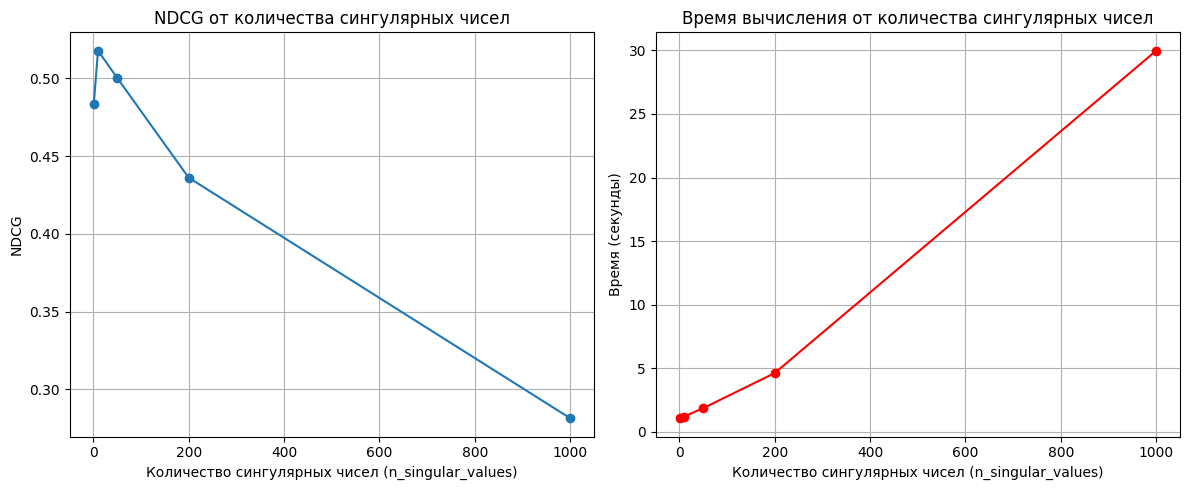

In [36]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(n_singular_values, ndsg_values, marker='o')
plt.title('NDCG от количества сингулярных чисел')
plt.xlabel('Количество сингулярных чисел (n_singular_values)')
plt.ylabel('NDCG')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_singular_values, time_values, marker='o', color='red')
plt.title('Время вычисления от количества сингулярных чисел')
plt.xlabel('Количество сингулярных чисел (n_singular_values)')
plt.ylabel('Время (секунды)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [40]:
test_grouped

,user_id,item_ratings,svd,pred_ratings,plot_svd,svd_10
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9...",0.000000,"[211, 875, 877, 1940, 889, 1497, 499, 496, 947...",0.315465,0.667642
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ...",0.456342,"[211, 875, 877, 1940, 889, 496, 947, 876, 638,...",0.305899,0.917811
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92...",0.000000,"[875, 877, 1940, 889, 1497, 947, 876, 2097, 91...",0.188207,0.152210
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097...",0.356207,"[877, 510, 876, 638, 242, 449, 2097, 1203, 820...",0.000000,0.465060
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113...",0.685073,"[875, 2168, 877, 1940, 889, 1497, 499, 510, 49...",0.632077,0.915866
...,...,...,...,...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21...",0.454946,"[875, 877, 1497, 496, 947, 876, 638, 94, 262, ...",0.217308,0.441197
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16...",0.000000,"[877, 1940, 876, 1167, 381, 0, 47, 775, 2214, ...",0.294298,0.612691
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13...",0.150190,"[1497, 94, 298, 47, 462, 2119, 596, 901, 1396,...",0.292890,0.584066
1145,5352,{2279: 4},0.000000,"[875, 2168, 877, 1497, 499, 510, 496, 947, 876...",0.000000,0.000000


In [39]:
recs = make_svd_recommendations(interactions, 10, 100)
result("svd_10", recs, test_grouped)
test_grouped["svd_10"].mean()

0.5178483514428545

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [41]:
import numpy as np
from scipy.sparse import coo_array, csr_matrix
from implicit.als import AlternatingLeastSquares
from typing import Union

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):

    interactions_csr = csr_matrix(interactions)

    model = AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        alpha=alpha,
        calculate_training_loss=False
    )

    weighted_interactions = interactions_csr * alpha
    model.fit(weighted_interactions)

    n_users, n_items = interactions_csr.shape

    recommendations = np.zeros((n_users, top_k), dtype=np.int32)

    for user_id in range(n_users):
        user_interactions = interactions_csr[user_id:user_id+1]
        recommended_items, scores = model.recommend(user_id, user_interactions, N=top_k)
        recommendations[user_id] = recommended_items

    return recommendations

In [42]:
recs = make_als_recommendations(coo_interactions)
assert recs.shape == (interactions.shape[0], 100)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
result("als", recs, test_grouped)
test_grouped["als"].mean()

0.4777477985277186

In [44]:
test_grouped

,user_id,item_ratings,svd,pred_ratings,plot_svd,svd_10,als
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9...",0.000000,"[211, 875, 877, 1940, 889, 1497, 499, 496, 947...",0.315465,0.667642,0.662100
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ...",0.456342,"[211, 875, 877, 1940, 889, 496, 947, 876, 638,...",0.305899,0.917811,0.839407
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92...",0.000000,"[875, 877, 1940, 889, 1497, 947, 876, 2097, 91...",0.188207,0.152210,0.000000
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097...",0.356207,"[877, 510, 876, 638, 242, 449, 2097, 1203, 820...",0.000000,0.465060,0.306453
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113...",0.685073,"[875, 2168, 877, 1940, 889, 1497, 499, 510, 49...",0.632077,0.915866,0.916070
...,...,...,...,...,...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21...",0.454946,"[875, 877, 1497, 496, 947, 876, 638, 94, 262, ...",0.217308,0.441197,0.480869
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16...",0.000000,"[877, 1940, 876, 1167, 381, 0, 47, 775, 2214, ...",0.294298,0.612691,0.598049
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13...",0.150190,"[1497, 94, 298, 47, 462, 2119, 596, 901, 1396,...",0.292890,0.584066,0.636698
1145,5352,{2279: 4},0.000000,"[875, 2168, 877, 1497, 499, 510, 496, 947, 876...",0.000000,0.000000,0.160053


In [45]:
import optuna

def objective_als(trial, interactions, test_result):
    params = {
        "factors": trial.suggest_int("factors", 10, 100),
        "alpha": trial.suggest_float("alpha", 0.1, 10, log=True),
        "regularization": trial.suggest_float("regularization", 0.01, 10, log=True),
    }
    recs = make_als_recommendations(interactions, **params)
    result("optuna_als", recs, test_result)
    score = test_result["optuna_als"].mean()

    return score

In [46]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, coo_interactions, test_grouped), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(coo_interactions, **study.best_params)
result("als_base", recs, test_grouped)

[I 2025-03-02 18:48:33,460] A new study created in memory with name: no-name-e957b517-4054-48ac-b001-f35a8e752dd2


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:48:53,193] Trial 3 finished with value: 0.4861859975518483 and parameters: {'factors': 30, 'alpha': 1.4995107927361564, 'regularization': 5.731152751340843}. Best is trial 3 with value: 0.4861859975518483.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:48:54,569] Trial 2 finished with value: 0.48556617343062747 and parameters: {'factors': 20, 'alpha': 0.1331385645925516, 'regularization': 0.02658172893181765}. Best is trial 3 with value: 0.4861859975518483.
[I 2025-03-02 18:48:54,605] Trial 7 finished with value: 0.41287139340373274 and parameters: {'factors': 39, 'alpha': 5.191315397449713, 'regularization': 2.34190216892789}. Best is trial 3 with value: 0.4861859975518483.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:48:55,776] Trial 6 finished with value: 0.49175903076367283 and parameters: {'factors': 56, 'alpha': 0.58694384869794, 'regularization': 0.20233183621885725}. Best is trial 6 with value: 0.49175903076367283.
[I 2025-03-02 18:48:55,914] Trial 1 finished with value: 0.4941437331806942 and parameters: {'factors': 56, 'alpha': 0.5311372556900188, 'regularization': 1.9909055135263107}. Best is trial 1 with value: 0.4941437331806942.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:48:57,610] Trial 5 finished with value: 0.423037341816454 and parameters: {'factors': 55, 'alpha': 3.9566657964346312, 'regularization': 1.9658861706232118}. Best is trial 1 with value: 0.4941437331806942.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:00,669] Trial 0 finished with value: 0.3854810654677666 and parameters: {'factors': 78, 'alpha': 9.88694879547445, 'regularization': 1.0240183168566903}. Best is trial 1 with value: 0.4941437331806942.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:01,039] Trial 4 finished with value: 0.48121924994202114 and parameters: {'factors': 77, 'alpha': 0.30038982417389665, 'regularization': 2.6422913584259433}. Best is trial 1 with value: 0.4941437331806942.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:15,822] Trial 8 finished with value: 0.4552922703580848 and parameters: {'factors': 33, 'alpha': 2.737642781760902, 'regularization': 3.2058092130793665}. Best is trial 1 with value: 0.4941437331806942.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:17,293] Trial 9 finished with value: 0.49907546273220216 and parameters: {'factors': 36, 'alpha': 0.5959059180859356, 'regularization': 1.8047550627781073}. Best is trial 9 with value: 0.49907546273220216.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:17,636] Trial 12 finished with value: 0.40541410993946897 and parameters: {'factors': 38, 'alpha': 5.591412829361461, 'regularization': 0.05822217542556934}. Best is trial 9 with value: 0.49907546273220216.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:18,166] Trial 11 finished with value: 0.5013441291253077 and parameters: {'factors': 34, 'alpha': 0.595020958857333, 'regularization': 8.350713301473297}. Best is trial 11 with value: 0.5013441291253077.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:23,183] Trial 13 finished with value: 0.4527778285967522 and parameters: {'factors': 50, 'alpha': 0.1018680673047508, 'regularization': 0.07005235788853485}. Best is trial 11 with value: 0.5013441291253077.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:25,296] Trial 10 finished with value: 0.4715263924472138 and parameters: {'factors': 85, 'alpha': 1.3129580923262132, 'regularization': 6.587685791714896}. Best is trial 11 with value: 0.5013441291253077.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:29,793] Trial 14 finished with value: 0.4773987429893917 and parameters: {'factors': 70, 'alpha': 0.1349988923494717, 'regularization': 1.9544397418338493}. Best is trial 11 with value: 0.5013441291253077.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:30,438] Trial 15 finished with value: 0.40495349286514726 and parameters: {'factors': 90, 'alpha': 7.860686848807465, 'regularization': 4.820081224310942}. Best is trial 11 with value: 0.5013441291253077.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:37,285] Trial 16 finished with value: 0.5066633878806506 and parameters: {'factors': 15, 'alpha': 0.375404936000085, 'regularization': 3.383590275936133}. Best is trial 16 with value: 0.5066633878806506.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:38,225] Trial 17 finished with value: 0.4990117176390108 and parameters: {'factors': 10, 'alpha': 0.1326662947015015, 'regularization': 0.19626882204425242}. Best is trial 16 with value: 0.5066633878806506.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:40,905] Trial 20 finished with value: 0.504848002910535 and parameters: {'factors': 13, 'alpha': 0.8648292638491271, 'regularization': 8.76742559040089}. Best is trial 16 with value: 0.5066633878806506.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:43,265] Trial 18 finished with value: 0.4938603742211518 and parameters: {'factors': 58, 'alpha': 0.6109658090935957, 'regularization': 0.4962950732487399}. Best is trial 16 with value: 0.5066633878806506.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:46,423] Trial 21 finished with value: 0.5024732958158888 and parameters: {'factors': 17, 'alpha': 0.2790147115282064, 'regularization': 0.5431985135642015}. Best is trial 16 with value: 0.5066633878806506.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:49,125] Trial 19 finished with value: 0.469589699935929 and parameters: {'factors': 100, 'alpha': 1.3096700727237045, 'regularization': 9.750975692296795}. Best is trial 16 with value: 0.5066633878806506.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 18:49:49,477] Trial 22 finished with value: 0.5128982867168459 and parameters: {'factors': 10, 'alpha': 0.3145972726898244, 'regularization': 0.5477937576372627}. Best is trial 22 with value: 0.5128982867168459.
[I 2025-03-02 18:49:50,688] Trial 23 finished with value: 0.5075102710807373 and parameters: {'factors': 11, 'alpha': 0.4000131692921321, 'regularization': 0.6848185353093049}. Best is trial 22 with value: 0.5128982867168459.
[I 2025-03-02 18:49:54,806] Trial 25 finished with value: 0.5075214875669333 and parameters: {'factors': 11, 'alpha': 0.29288508133656826, 'regularization': 0.7507115879861471}. Best is trial 22 with value: 0.5128982867168459.
[I 2025-03-02 18:49:55,608] Trial 24 finished with value: 0.5086170087451317 and parameters: {'factors': 10, 'alpha': 0.2775842940794106, 'regularization': 0.2618096982242321}. Best is trial 22 with value: 0.5128982867168459.
[I 2025-03-02 18:49:57,005] Trial 26 finished with value: 0.5067886216386847 and parameters: {'

Лучшее значение: 0.5128982867168459
Лучшие параметры: {'factors': 10, 'alpha': 0.3145972726898244, 'regularization': 0.5477937576372627}


  0%|          | 0/15 [00:00<?, ?it/s]

In [48]:
recs = recs = make_als_recommendations(interactions, **study.best_params)
result("als_best", recs, test_grouped)

  0%|          | 0/15 [00:00<?, ?it/s]

In [50]:
ndcs_cols = ["svd_10", "als_best"]
for col in ndcs_cols:
    print(f"{col:20s}: {test_grouped[col].mean():.4f}")

svd_10              : 0.5178
als_best            : 0.5122


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [51]:
df_movies = pd.read_csv("ml-1m/movies.dat", sep='::', names=['item_id', 'name', 'category'], engine='python', encoding="ISO-8859-1")
movie_map = dict(zip(df_movies["item_id"].to_list(), df_movies["name"].to_list()))

In [52]:
if isinstance(interactions, np.ndarray):
    interactions_csr = csr_matrix(interactions)
elif isinstance(interactions, coo_array):
    interactions_csr = interactions.tocsr()
else:
    raise ValueError("interactions должен быть np.ndarray или coo_array")

model = AlternatingLeastSquares(
        **study.best_params,
        iterations=15,
        calculate_training_loss=False)

weighted_interactions = interactions_csr * study.best_params['alpha']
model.fit(weighted_interactions)

  0%|          | 0/15 [00:00<?, ?it/s]

In [53]:
def explain_recommendations(model, interactions_csr, movie_map, user_id, top_k=1):
    
    recommended_items, scores = model.recommend(user_id, interactions_csr[user_id], N=top_k)
    recommended_titles = [movie_map.get(item, f"Movie {item}") for item in recommended_items]

    item_id = recommended_items[0]
    explanation = model.explain(user_id, interactions_csr, item_id)
    explained_movies = [movie_map.get(idx, f"Movie {idx}") for idx, _ in explanation[1]]
    contributions = [score for _, score in explanation[1]]

    df_explain = pd.DataFrame({"Фильм": explained_movies, "Вклад": contributions})
    df_explain = df_explain.sort_values(by="Вклад", ascending=False)

    return recommended_titles, df_explain

In [54]:
user_id = 400

recommended, explanation_df = explain_recommendations(model, interactions_csr, movie_map, user_id)
print("Рекомендованные фильмы:", recommended)
print("\nОбъяснение рекомендации:")
print(explanation_df)

Рекомендованные фильмы: ['Dance with Me (1998)']

Объяснение рекомендации:
                                     Фильм     Вклад
0                       Double Team (1997)  0.050203
1                     Mr. Wonderful (1993)  0.044222
2  Wooden Man's Bride, The (Wu Kui) (1994)  0.041418
3       Don't Look in the Basement! (1973)  0.028771
4                 Mummy's Tomb, The (1942)  0.021535
5                            Cocoon (1985)  0.019303
6                           Zone 39 (1997)  0.018489
7            Farinelli: il castrato (1994)  0.012892
8             Bringing Out the Dead (1999)  0.007525
9               Violets Are Blue... (1986)  0.007520


In [55]:
user_id = 900

recommended, explanation_df = explain_recommendations(model, interactions_csr, movie_map, user_id)
print("Рекомендованные фильмы:", recommended)
print("\nОбъяснение рекомендации:")
print(explanation_df)

Рекомендованные фильмы: ['Far Off Place, A (1993)']

Объяснение рекомендации:
                                    Фильм     Вклад
0    Billy's Hollywood Screen Kiss (1997)  0.076466
1        Happiest Millionaire, The (1967)  0.055539
2                    Dance with Me (1998)  0.053391
3  Something Wicked This Way Comes (1983)  0.048929
4                Nothing in Common (1986)  0.030791
5           Hot Lead and Cold Feet (1978)  0.027695
6           Take the Money and Run (1969)  0.026428
7          Barefoot Executive, The (1971)  0.025650
8                        Following (1998)  0.025032
9                           Pecker (1998)  0.023675


In [56]:
user_id = 2500

recommended, explanation_df = explain_recommendations(model, interactions_csr, movie_map, user_id)
print("Рекомендованные фильмы:", recommended)
print("\nОбъяснение рекомендации:")
print(explanation_df)

Рекомендованные фильмы: ['Dance with Me (1998)']

Объяснение рекомендации:
                                Фильм     Вклад
0                    Wood, The (1999)  0.072430
1                Mr. Wonderful (1993)  0.034370
2          Fear of a Black Hat (1993)  0.032642
3  Don't Look in the Basement! (1973)  0.028533
4       Little Shop of Horrors (1986)  0.026927
5            Mummy's Tomb, The (1942)  0.021380
6                Pushing Hands (1992)  0.016227
7           Soldier's Story, A (1984)  0.014541
8           I Saw What You Did (1965)  0.012385
9                  Three Kings (1999)  0.011798


In [57]:
user_id = 12

recommended, explanation_df = explain_recommendations(model, interactions_csr, movie_map, user_id)
print("Рекомендованные фильмы:", recommended)
print("\nОбъяснение рекомендации:")
print(explanation_df)

Рекомендованные фильмы: ['Mr. Wonderful (1993)']

Объяснение рекомендации:
                           Фильм     Вклад
0      Little Princess, A (1995)  0.075055
1          Poetic Justice (1993)  0.069929
2  Farinelli: il castrato (1994)  0.068692
3     Fear of a Black Hat (1993)  0.063301
4             Double Team (1997)  0.053791
5         Beautiful Girls (1996)  0.036819
6           Dance with Me (1998)  0.035216
7   Three Caballeros, The (1945)  0.035184
8          Jack and Sarah (1995)  0.030760
9         Nothing to Lose (1994)  0.027533


In [58]:
user_id = 912

recommended, explanation_df = explain_recommendations(model, interactions_csr, movie_map, user_id)
print("Рекомендованные фильмы:", recommended)
print("\nОбъяснение рекомендации:")
print(explanation_df)

Рекомендованные фильмы: ['Great Dictator, The (1940)']

Объяснение рекомендации:
                           Фильм     Вклад
0            Magic Hunter (1994)  0.023780
1                   Ronin (1998)  0.019707
2  Farinelli: il castrato (1994)  0.019390
3            12 Angry Men (1957)  0.017885
4          Poetic Justice (1993)  0.017627
5          U.S. Marshalls (1998)  0.017413
6             Normal Life (1996)  0.016779
7           39 Steps, The (1935)  0.016028
8   Story of Xinghua, The (1993)  0.014792
9           Seven (Se7en) (1995)  0.013967


##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [128]:
test_result = df_test.groupby('user_id').apply(
    lambda x: dict([(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.rating), key=lambda x: x[1])])
    ).reset_index()

test_result.rename({0:'item_ratings'}, axis=1, inplace=True)
test_result

/var/folders/34/9lmn_1px5cs289tjl5rn7cs80000gn/T/ipykernel_65197/3391031236.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_result = df_test.groupby('user_id').apply(


,user_id,item_ratings
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9..."
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ..."
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92..."
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097..."
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113..."
...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21..."
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16..."
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13..."
1145,5352,{2279: 4}


In [129]:
def result(name: str,
           recs: np.array,
           test_result: pd.DataFrame,
           ):
    col_pred = name

    def get_pred_rating(row):
        item_dict = row["item_ratings"]
        return [item_dict.get(item, 0) for item in row[col_pred]]

    def dcg(relevance):
        positions = np.arange(len(relevance)) + 1
        dcg_score = np.sum(relevance / np.log2(positions + 1))
        return dcg_score

    def ndcg(relevance):
        dcg_r = dcg(relevance)
        dcg_i = dcg(sorted(relevance, reverse=True))
        if dcg_i > 0:
            return dcg_r / dcg_i
        return 0
    test_result[col_pred] = test_result["user_id"].apply(lambda uid: recs[uid])
    test_result[col_pred] = test_result.apply(get_pred_rating, axis=1)
    test_result[col_pred] = test_result[col_pred].apply(ndcg)

In [130]:
import optuna

def objective_als(trial, interactions, test_result):
    params = {
        "factors": trial.suggest_int("factors", 10, 50),
        "alpha": trial.suggest_float("alpha", 0.01, 1, log=True),
        "regularization": trial.suggest_float("regularization", 0.1, 5, log=True),
    }
    recs = make_als_recommendations(interactions, **params)
    result("optuna_als", recs, test_result)
    score = test_result["optuna_als"].mean()

    return score

In [131]:
import optuna

def objective_svd(trial, interactions, test_result):
    params = {
        "n_singular_values": trial.suggest_int("n_singular_values", 1, 50)
    }
    recs = make_svd_recommendations(interactions, **params)
    result("optuna_svd", recs, test_result)
    score = test_result["optuna_svd"].mean()

    return score

In [132]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_svd(trial, coo_interactions, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_svd_recommendations(coo_interactions, **study.best_params)
result("svd_base", recs, test_result)

[I 2025-03-02 20:26:18,987] A new study created in memory with name: no-name-ad5562b3-6933-4bbf-b9f1-6a4fc78fb6aa
[I 2025-03-02 20:26:21,310] Trial 0 finished with value: 0.5016240828607047 and parameters: {'n_singular_values': 47}. Best is trial 0 with value: 0.5016240828607047.
[I 2025-03-02 20:26:21,820] Trial 3 finished with value: 0.509740434612027 and parameters: {'n_singular_values': 17}. Best is trial 3 with value: 0.509740434612027.
[I 2025-03-02 20:26:21,879] Trial 4 finished with value: 0.492039029512887 and parameters: {'n_singular_values': 2}. Best is trial 3 with value: 0.509740434612027.
[I 2025-03-02 20:26:23,578] Trial 2 finished with value: 0.5057147559091643 and parameters: {'n_singular_values': 38}. Best is trial 3 with value: 0.509740434612027.
[I 2025-03-02 20:26:23,878] Trial 7 finished with value: 0.5069610484439271 and parameters: {'n_singular_values': 30}. Best is trial 3 with value: 0.509740434612027.
[I 2025-03-02 20:26:23,930] Trial 6 finished with value: 0

Лучшее значение: 0.5226953287347962
Лучшие параметры: {'n_singular_values': 9}


In [133]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, coo_interactions, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(coo_interactions, **study.best_params)
result("als_base", recs, test_result)

[I 2025-03-02 20:26:45,199] A new study created in memory with name: no-name-b8d81f9f-b854-4b12-98e0-a0997f00d283


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:03,279] Trial 4 finished with value: 0.22476436301351993 and parameters: {'factors': 25, 'alpha': 0.01933849376232641, 'regularization': 2.3018298699033917}. Best is trial 4 with value: 0.22476436301351993.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:04,092] Trial 6 finished with value: 0.47405257497591224 and parameters: {'factors': 24, 'alpha': 0.03817927676309378, 'regularization': 1.275456272730518}. Best is trial 6 with value: 0.47405257497591224.
[I 2025-03-02 20:27:04,248] Trial 7 finished with value: 0.5042821508599088 and parameters: {'factors': 17, 'alpha': 0.29789975470264335, 'regularization': 1.3778215728307246}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:04,676] Trial 0 finished with value: 0.1160603429971382 and parameters: {'factors': 27, 'alpha': 0.010171261066780244, 'regularization': 3.4039616030188307}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:05,903] Trial 1 finished with value: 0.4774598456073564 and parameters: {'factors': 31, 'alpha': 0.05413245750624276, 'regularization': 3.505528164159859}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:06,902] Trial 2 finished with value: 0.47439188794044046 and parameters: {'factors': 38, 'alpha': 0.15602974379872334, 'regularization': 0.16916819897304453}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:07,955] Trial 3 finished with value: 0.4944301806949178 and parameters: {'factors': 46, 'alpha': 0.19780097041008018, 'regularization': 3.5736719353110304}. Best is trial 7 with value: 0.5042821508599088.
[I 2025-03-02 20:27:08,115] Trial 5 finished with value: 0.4835060584354085 and parameters: {'factors': 26, 'alpha': 0.10662440687112681, 'regularization': 0.48271580206113834}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:24,488] Trial 8 finished with value: 0.48426356095004053 and parameters: {'factors': 22, 'alpha': 0.11439920875120177, 'regularization': 0.4861371484986862}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:25,444] Trial 15 finished with value: 0.4836246464046319 and parameters: {'factors': 43, 'alpha': 0.01308758301164466, 'regularization': 0.6855576636571296}. Best is trial 7 with value: 0.5042821508599088.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:25,649] Trial 11 finished with value: 0.5048654270038756 and parameters: {'factors': 13, 'alpha': 0.21012442572024148, 'regularization': 0.468359405680751}. Best is trial 11 with value: 0.5048654270038756.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:26,541] Trial 14 finished with value: 0.502911678094072 and parameters: {'factors': 14, 'alpha': 0.22879658524550106, 'regularization': 0.7068121240542582}. Best is trial 11 with value: 0.5048654270038756.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:27,330] Trial 10 finished with value: 0.49115531450634464 and parameters: {'factors': 49, 'alpha': 0.291489020818572, 'regularization': 2.5442864630302036}. Best is trial 11 with value: 0.5048654270038756.
[I 2025-03-02 20:27:27,458] Trial 12 finished with value: 0.5005019097166632 and parameters: {'factors': 28, 'alpha': 0.3758307231810835, 'regularization': 0.25720449289327285}. Best is trial 11 with value: 0.5048654270038756.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:29,599] Trial 9 finished with value: 0.49883397160104626 and parameters: {'factors': 37, 'alpha': 0.4682492813534221, 'regularization': 0.3366358060519733}. Best is trial 11 with value: 0.5048654270038756.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:30,680] Trial 13 finished with value: 0.4968471760589729 and parameters: {'factors': 42, 'alpha': 0.47673433172172275, 'regularization': 0.13479362217067833}. Best is trial 11 with value: 0.5048654270038756.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:43,149] Trial 18 finished with value: 0.508154795931488 and parameters: {'factors': 12, 'alpha': 0.707088489137229, 'regularization': 0.23524033788042487}. Best is trial 18 with value: 0.508154795931488.
[I 2025-03-02 20:27:43,181] Trial 17 finished with value: 0.5060886968639355 and parameters: {'factors': 12, 'alpha': 0.8899132251654154, 'regularization': 0.1848178378217669}. Best is trial 18 with value: 0.508154795931488.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:44,302] Trial 20 finished with value: 0.5094016209729909 and parameters: {'factors': 10, 'alpha': 0.8758943815358378, 'regularization': 0.2405216946945472}. Best is trial 20 with value: 0.5094016209729909.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:45,512] Trial 19 finished with value: 0.5093464960866307 and parameters: {'factors': 11, 'alpha': 0.6470075673919982, 'regularization': 0.25867589124796636}. Best is trial 20 with value: 0.5094016209729909.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:45,983] Trial 16 finished with value: 0.49844028613800256 and parameters: {'factors': 28, 'alpha': 0.21926197113437812, 'regularization': 2.1567757533222327}. Best is trial 20 with value: 0.5094016209729909.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:46,606] Trial 21 finished with value: 0.5099668142400511 and parameters: {'factors': 10, 'alpha': 0.7468110451208678, 'regularization': 1.2740448255695884}. Best is trial 21 with value: 0.5099668142400511.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:27:49,037] Trial 22 finished with value: 0.5099497952363753 and parameters: {'factors': 11, 'alpha': 0.6362374941390657, 'regularization': 1.3503549141645714}. Best is trial 21 with value: 0.5099668142400511.
[I 2025-03-02 20:27:51,128] Trial 23 finished with value: 0.5096370744487955 and parameters: {'factors': 11, 'alpha': 0.7734191201675924, 'regularization': 1.3797121364431266}. Best is trial 21 with value: 0.5099668142400511.
[I 2025-03-02 20:27:59,758] Trial 24 finished with value: 0.508130635565806 and parameters: {'factors': 11, 'alpha': 0.8906672966804512, 'regularization': 0.21727364133264704}. Best is trial 21 with value: 0.5099668142400511.
[I 2025-03-02 20:27:59,969] Trial 27 finished with value: 0.49833738710202413 and parameters: {'factors': 18, 'alpha': 0.9203301557595277, 'regularization': 0.12420873962381726}. Best is trial 21 with value: 0.5099668142400511.
[I 2025-03-02 20:28:00,037] Trial 25 finished with value: 0.507959637502866 and parameters: {'

Лучшее значение: 0.5106019956649388
Лучшие параметры: {'factors': 10, 'alpha': 0.7789359007978024, 'regularization': 0.11194083984495823}


  0%|          | 0/15 [00:00<?, ?it/s]

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)

In [134]:
interactions_bin_1 = coo_interactions.copy()
interactions_bin_1.data = np.ones_like(interactions_bin_1.data)

In [135]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_svd(trial, interactions_bin_1, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_svd_recommendations(interactions_bin_1, **study.best_params)
result("svd_1", recs, test_result)


[I 2025-03-02 20:28:32,593] A new study created in memory with name: no-name-e8ca4349-386b-48f5-baca-e71a78046327
[I 2025-03-02 20:28:34,735] Trial 3 finished with value: 0.48825139902264475 and parameters: {'n_singular_values': 41}. Best is trial 3 with value: 0.48825139902264475.
[I 2025-03-02 20:28:35,789] Trial 4 finished with value: 0.4888568663318204 and parameters: {'n_singular_values': 37}. Best is trial 4 with value: 0.4888568663318204.
[I 2025-03-02 20:28:37,019] Trial 0 finished with value: 0.48825139902264475 and parameters: {'n_singular_values': 41}. Best is trial 4 with value: 0.4888568663318204.
[I 2025-03-02 20:28:37,345] Trial 7 finished with value: 0.49282729480207266 and parameters: {'n_singular_values': 27}. Best is trial 7 with value: 0.49282729480207266.
[I 2025-03-02 20:28:38,638] Trial 1 finished with value: 0.48976545511934994 and parameters: {'n_singular_values': 34}. Best is trial 7 with value: 0.49282729480207266.
[I 2025-03-02 20:28:39,069] Trial 6 finished

Лучшее значение: 0.5045906201344602
Лучшие параметры: {'n_singular_values': 9}


In [136]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, interactions_bin_1, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(interactions_bin_1, **study.best_params)
result("als_1", recs, test_result)

[I 2025-03-02 20:28:53,517] A new study created in memory with name: no-name-77bc9483-ba93-4587-984a-4c9c37b8bca6


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:10,741] Trial 7 finished with value: 0.4737904591250978 and parameters: {'factors': 19, 'alpha': 0.07657567742995797, 'regularization': 3.8915118290197195}. Best is trial 7 with value: 0.4737904591250978.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:11,336] Trial 5 finished with value: 0.33700335047079094 and parameters: {'factors': 32, 'alpha': 0.010475203170529152, 'regularization': 0.13463835756135648}. Best is trial 7 with value: 0.4737904591250978.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:11,897] Trial 2 finished with value: 0.4909528303590637 and parameters: {'factors': 11, 'alpha': 0.13000412573798462, 'regularization': 0.6859719650368562}. Best is trial 2 with value: 0.4909528303590637.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:12,725] Trial 6 finished with value: 0.48253668857284704 and parameters: {'factors': 15, 'alpha': 0.18782377901684558, 'regularization': 0.47020800509120764}. Best is trial 2 with value: 0.4909528303590637.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:14,198] Trial 1 finished with value: 0.47880041498987974 and parameters: {'factors': 32, 'alpha': 0.11966955880966205, 'regularization': 2.1564303696646174}. Best is trial 2 with value: 0.4909528303590637.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:15,057] Trial 0 finished with value: 0.46352998963938574 and parameters: {'factors': 49, 'alpha': 0.1411628909831962, 'regularization': 3.5102537585998497}. Best is trial 2 with value: 0.4909528303590637.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:16,186] Trial 3 finished with value: 0.5050196463817145 and parameters: {'factors': 50, 'alpha': 0.2220760528302723, 'regularization': 4.142301586888138}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:17,699] Trial 4 finished with value: 0.4684759100580038 and parameters: {'factors': 39, 'alpha': 0.2637269090635188, 'regularization': 0.5951224439695202}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:32,762] Trial 8 finished with value: 0.4737904591250978 and parameters: {'factors': 11, 'alpha': 0.0222432100153989, 'regularization': 0.24369553564797883}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:34,187] Trial 11 finished with value: 0.360107841168468 and parameters: {'factors': 24, 'alpha': 0.04260603748093159, 'regularization': 4.560303117453342}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:34,734] Trial 9 finished with value: 0.48842080255895526 and parameters: {'factors': 39, 'alpha': 0.9197472532229702, 'regularization': 0.1974279453628317}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:36,377] Trial 14 finished with value: 0.2424984813168287 and parameters: {'factors': 44, 'alpha': 0.014269314891983157, 'regularization': 0.46395435197463186}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:37,393] Trial 10 finished with value: 0.48519913893002775 and parameters: {'factors': 39, 'alpha': 0.35151494574834075, 'regularization': 2.2974666856421}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:37,982] Trial 12 finished with value: 0.5017784345018956 and parameters: {'factors': 34, 'alpha': 0.32608449906723863, 'regularization': 4.454113173281795}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:39,499] Trial 13 finished with value: 0.4697392573417388 and parameters: {'factors': 41, 'alpha': 0.03768439629962407, 'regularization': 0.5066713509237983}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:44,680] Trial 15 finished with value: 0.46594511931114857 and parameters: {'factors': 44, 'alpha': 0.04994553130288074, 'regularization': 0.1098409409278254}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:58,165] Trial 16 finished with value: 0.49386113364032636 and parameters: {'factors': 17, 'alpha': 0.4759276692499573, 'regularization': 0.16622449748375712}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:29:59,010] Trial 19 finished with value: 0.49146113512742595 and parameters: {'factors': 25, 'alpha': 0.4531317559030471, 'regularization': 1.3566782690588985}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:30:00,888] Trial 20 finished with value: 0.490941971541793 and parameters: {'factors': 26, 'alpha': 0.5897392135638218, 'regularization': 1.1412770922931998}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:30:01,294] Trial 18 finished with value: 0.47891768710163196 and parameters: {'factors': 49, 'alpha': 0.40290020163991047, 'regularization': 1.0838078893841858}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:30:01,847] Trial 21 finished with value: 0.491781477357741 and parameters: {'factors': 26, 'alpha': 0.502089261877867, 'regularization': 1.8216390264114055}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:30:05,217] Trial 17 finished with value: 0.4817019261592786 and parameters: {'factors': 50, 'alpha': 0.5239175749432045, 'regularization': 1.485766362388817}. Best is trial 3 with value: 0.5050196463817145.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:30:08,216] Trial 22 finished with value: 0.48227667106480465 and parameters: {'factors': 50, 'alpha': 0.5692360485029873, 'regularization': 1.3567063056842552}. Best is trial 3 with value: 0.5050196463817145.
[I 2025-03-02 20:30:13,302] Trial 23 finished with value: 0.48398819822203076 and parameters: {'factors': 50, 'alpha': 0.5545665469306389, 'regularization': 1.4134444773568935}. Best is trial 3 with value: 0.5050196463817145.
[I 2025-03-02 20:30:20,253] Trial 28 finished with value: 0.47902187000566465 and parameters: {'factors': 19, 'alpha': 0.2232941243355407, 'regularization': 0.29544586995772226}. Best is trial 3 with value: 0.5050196463817145.
[I 2025-03-02 20:30:20,484] Trial 27 finished with value: 0.5002681909347797 and parameters: {'factors': 36, 'alpha': 0.22094640064406512, 'regularization': 2.511372403921846}. Best is trial 3 with value: 0.5050196463817145.
[I 2025-03-02 20:30:21,227] Trial 24 finished with value: 0.48308238386652647 and parameters: {'

Лучшее значение: 0.5050196463817145
Лучшие параметры: {'factors': 50, 'alpha': 0.2220760528302723, 'regularization': 4.142301586888138}


  0%|          | 0/15 [00:00<?, ?it/s]

2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0

In [139]:
interactions_bin_2 = coo_interactions.copy()
interactions_bin_2.data = np.where(interactions_bin_2.data >= 4, 1, 0)

In [138]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_svd(trial, interactions_bin_2, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_svd_recommendations(interactions_bin_2, **study.best_params)
result("svd_2", recs, test_result)

[I 2025-03-02 20:31:01,345] A new study created in memory with name: no-name-97849565-0b80-48b2-b280-b746e63ab913
[I 2025-03-02 20:31:03,072] Trial 1 finished with value: 0.4676863580156485 and parameters: {'n_singular_values': 15}. Best is trial 1 with value: 0.4676863580156485.
[I 2025-03-02 20:31:03,608] Trial 0 finished with value: 0.469740233367778 and parameters: {'n_singular_values': 14}. Best is trial 0 with value: 0.469740233367778.
[I 2025-03-02 20:31:04,569] Trial 4 finished with value: 0.4618073121505618 and parameters: {'n_singular_values': 38}. Best is trial 0 with value: 0.469740233367778.
[I 2025-03-02 20:31:04,813] Trial 7 finished with value: 0.4670442153546602 and parameters: {'n_singular_values': 19}. Best is trial 0 with value: 0.469740233367778.
[I 2025-03-02 20:31:05,171] Trial 2 finished with value: 0.4708166532242989 and parameters: {'n_singular_values': 13}. Best is trial 2 with value: 0.4708166532242989.
[I 2025-03-02 20:31:06,715] Trial 5 finished with value

Лучшее значение: 0.48035918798738036
Лучшие параметры: {'n_singular_values': 7}


In [140]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, interactions_bin_2, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(interactions_bin_2, **study.best_params)
result("als_2", recs, test_result)

[I 2025-03-02 20:31:28,845] A new study created in memory with name: no-name-49e346c3-a766-427d-8296-9d78a7d9f2b0


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:31:46,409] Trial 5 finished with value: 0.22451325880895445 and parameters: {'factors': 20, 'alpha': 0.013227726258978657, 'regularization': 0.22458663383206962}. Best is trial 5 with value: 0.22451325880895445.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:31:48,631] Trial 7 finished with value: 0.46400657369403703 and parameters: {'factors': 40, 'alpha': 0.11487281647924318, 'regularization': 0.1930810183666696}. Best is trial 7 with value: 0.46400657369403703.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:31:48,939] Trial 0 finished with value: 0.4952152242919504 and parameters: {'factors': 47, 'alpha': 0.21452188272648942, 'regularization': 1.4529368963419853}. Best is trial 0 with value: 0.4952152242919504.
[I 2025-03-02 20:31:49,037] Trial 3 finished with value: 0.4742590887505545 and parameters: {'factors': 26, 'alpha': 0.11601115814360541, 'regularization': 1.7152694698137978}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:31:49,240] Trial 4 finished with value: 0.09278501609524939 and parameters: {'factors': 45, 'alpha': 0.02558822083733143, 'regularization': 3.208032875575577}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:31:50,504] Trial 1 finished with value: 0.3299295042254705 and parameters: {'factors': 42, 'alpha': 0.012655154639835945, 'regularization': 0.4096152339873136}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:31:50,903] Trial 2 finished with value: 0.4886634553889254 and parameters: {'factors': 19, 'alpha': 0.1706822606531571, 'regularization': 0.5721355324902395}. Best is trial 0 with value: 0.4952152242919504.
[I 2025-03-02 20:31:51,071] Trial 6 finished with value: 0.0968384052146637 and parameters: {'factors': 49, 'alpha': 0.01089391734668456, 'regularization': 1.7705895399739195}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:05,797] Trial 10 finished with value: 0.45746524590731696 and parameters: {'factors': 20, 'alpha': 0.03202218855287066, 'regularization': 1.1856332942446524}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:06,799] Trial 8 finished with value: 0.46766832274611264 and parameters: {'factors': 32, 'alpha': 0.19477450458052367, 'regularization': 0.15356554575125778}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:07,432] Trial 9 finished with value: 0.41991887724205157 and parameters: {'factors': 34, 'alpha': 0.015659213962020368, 'regularization': 2.202149300684103}. Best is trial 0 with value: 0.4952152242919504.
[I 2025-03-02 20:32:07,482] Trial 13 finished with value: 0.2196883237325975 and parameters: {'factors': 18, 'alpha': 0.014860780976630256, 'regularization': 1.1716066569350325}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:08,658] Trial 15 finished with value: 0.2884370676324754 and parameters: {'factors': 26, 'alpha': 0.032714627274884674, 'regularization': 1.4111419843017328}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:10,350] Trial 11 finished with value: 0.49352052689107645 and parameters: {'factors': 24, 'alpha': 0.38150579242447824, 'regularization': 0.599103776742269}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:11,184] Trial 12 finished with value: 0.4872023475921372 and parameters: {'factors': 27, 'alpha': 0.3274817710843446, 'regularization': 0.27485902870851714}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:15,443] Trial 14 finished with value: 0.49259571156089094 and parameters: {'factors': 43, 'alpha': 0.0836498423329935, 'regularization': 0.7787560774624479}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:25,427] Trial 16 finished with value: 0.42319903271699644 and parameters: {'factors': 38, 'alpha': 0.01985528716738182, 'regularization': 0.7409512840060951}. Best is trial 0 with value: 0.4952152242919504.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:27,075] Trial 19 finished with value: 0.516207034679579 and parameters: {'factors': 11, 'alpha': 0.5652913213933863, 'regularization': 0.5396927857732015}. Best is trial 19 with value: 0.516207034679579.
[I 2025-03-02 20:32:27,177] Trial 21 finished with value: 0.5115531179833742 and parameters: {'factors': 10, 'alpha': 0.608954544840541, 'regularization': 0.6705598869491288}. Best is trial 19 with value: 0.516207034679579.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:27,438] Trial 18 finished with value: 0.5037799938150359 and parameters: {'factors': 12, 'alpha': 0.3725960950709741, 'regularization': 0.6679018973173174}. Best is trial 19 with value: 0.516207034679579.
[I 2025-03-02 20:32:27,708] Trial 17 finished with value: 0.5139069180988892 and parameters: {'factors': 11, 'alpha': 0.7953931558597648, 'regularization': 3.627405062621853}. Best is trial 19 with value: 0.516207034679579.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:28,678] Trial 22 finished with value: 0.5147313081584713 and parameters: {'factors': 10, 'alpha': 0.8663086159380986, 'regularization': 0.6763762120476133}. Best is trial 19 with value: 0.516207034679579.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:32:30,552] Trial 20 finished with value: 0.5106645287019071 and parameters: {'factors': 11, 'alpha': 0.5283796853722496, 'regularization': 0.5498227348051358}. Best is trial 19 with value: 0.516207034679579.
[I 2025-03-02 20:32:36,017] Trial 23 finished with value: 0.5125185966176047 and parameters: {'factors': 13, 'alpha': 0.8257749941506705, 'regularization': 4.472730399841237}. Best is trial 19 with value: 0.516207034679579.
[I 2025-03-02 20:32:41,868] Trial 25 finished with value: 0.5144252796044148 and parameters: {'factors': 11, 'alpha': 0.9003521528850768, 'regularization': 2.9066831116071534}. Best is trial 19 with value: 0.516207034679579.
[I 2025-03-02 20:32:42,667] Trial 28 finished with value: 0.5186460741728144 and parameters: {'factors': 10, 'alpha': 0.9612711892776958, 'regularization': 4.768527408696596}. Best is trial 28 with value: 0.5186460741728144.
[I 2025-03-02 20:32:42,816] Trial 27 finished with value: 0.5180206307141936 and parameters: {'factor

Лучшее значение: 0.5186460741728144
Лучшие параметры: {'factors': 10, 'alpha': 0.9612711892776958, 'regularization': 4.768527408696596}


  0%|          | 0/15 [00:00<?, ?it/s]

3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1

In [150]:
interactions_bin_3 = coo_interactions.copy()
interactions_bin_3.data = np.where(interactions_bin_3.data >= 4, 1, -1)

In [151]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_svd(trial, interactions_bin_3, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_svd_recommendations(interactions_bin_3, **study.best_params)
result("svd_3", recs, test_result)

[I 2025-03-02 20:35:14,456] A new study created in memory with name: no-name-2fc69a29-d2d3-449e-a841-b874431480f2
[I 2025-03-02 20:35:16,241] Trial 0 finished with value: 0.49455793744514204 and parameters: {'n_singular_values': 12}. Best is trial 0 with value: 0.49455793744514204.
[I 2025-03-02 20:35:16,524] Trial 7 finished with value: 0.4663826608294705 and parameters: {'n_singular_values': 3}. Best is trial 0 with value: 0.49455793744514204.
[I 2025-03-02 20:35:17,723] Trial 5 finished with value: 0.4849402316248284 and parameters: {'n_singular_values': 42}. Best is trial 0 with value: 0.49455793744514204.
[I 2025-03-02 20:35:18,351] Trial 1 finished with value: 0.4898923582819253 and parameters: {'n_singular_values': 29}. Best is trial 0 with value: 0.49455793744514204.
[I 2025-03-02 20:35:18,733] Trial 4 finished with value: 0.49171058754381725 and parameters: {'n_singular_values': 9}. Best is trial 0 with value: 0.49455793744514204.
[I 2025-03-02 20:35:19,715] Trial 6 finished w

Лучшее значение: 0.49636629926800774
Лучшие параметры: {'n_singular_values': 16}


In [152]:

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, interactions_bin_3, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(interactions_bin_3, **study.best_params)
result("als_3", recs, test_result)

[I 2025-03-02 20:35:39,940] A new study created in memory with name: no-name-c68cb5ba-7df7-448e-8030-ffa21e687710


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:35:56,683] Trial 2 finished with value: 0.3009383138823697 and parameters: {'factors': 14, 'alpha': 0.0267520467995345, 'regularization': 1.4008717359389866}. Best is trial 2 with value: 0.3009383138823697.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:35:57,569] Trial 7 finished with value: 0.08972691407564094 and parameters: {'factors': 25, 'alpha': 0.012298685531068497, 'regularization': 3.0021503581947377}. Best is trial 2 with value: 0.3009383138823697.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:35:58,439] Trial 0 finished with value: 0.4742540540480619 and parameters: {'factors': 23, 'alpha': 0.0352894396592934, 'regularization': 0.18384473399357512}. Best is trial 0 with value: 0.4742540540480619.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:00,163] Trial 4 finished with value: 0.5042258600134881 and parameters: {'factors': 37, 'alpha': 0.7762252956658376, 'regularization': 0.10912426622004566}. Best is trial 4 with value: 0.5042258600134881.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:02,394] Trial 3 finished with value: 0.5067210453008975 and parameters: {'factors': 18, 'alpha': 0.4745693204848598, 'regularization': 0.3914734560895979}. Best is trial 3 with value: 0.5067210453008975.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:03,483] Trial 6 finished with value: 0.4850534823214233 and parameters: {'factors': 48, 'alpha': 0.3136117999459369, 'regularization': 1.6048017760877449}. Best is trial 3 with value: 0.5067210453008975.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:04,088] Trial 1 finished with value: 0.5065113200823416 and parameters: {'factors': 39, 'alpha': 0.5781054989863353, 'regularization': 4.315408915962326}. Best is trial 3 with value: 0.5067210453008975.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:04,460] Trial 5 finished with value: 0.4975170632950958 and parameters: {'factors': 34, 'alpha': 0.17512215070761383, 'regularization': 3.1089268795584686}. Best is trial 3 with value: 0.5067210453008975.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:16,914] Trial 8 finished with value: 0.10118158102281102 and parameters: {'factors': 41, 'alpha': 0.010610111608967188, 'regularization': 2.0825867990798352}. Best is trial 3 with value: 0.5067210453008975.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:20,046] Trial 10 finished with value: 0.519439452261595 and parameters: {'factors': 11, 'alpha': 0.8569534445802455, 'regularization': 0.1832730653186897}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:21,229] Trial 14 finished with value: 0.48417860575134863 and parameters: {'factors': 12, 'alpha': 0.11067676861560413, 'regularization': 4.421769863077095}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:21,841] Trial 11 finished with value: 0.16327806537785858 and parameters: {'factors': 43, 'alpha': 0.01105548797478234, 'regularization': 1.1032006906358265}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:22,415] Trial 9 finished with value: 0.46715704785790585 and parameters: {'factors': 50, 'alpha': 0.12791361964137443, 'regularization': 0.3390804676420408}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:23,099] Trial 12 finished with value: 0.1813560906333699 and parameters: {'factors': 39, 'alpha': 0.012436010464006863, 'regularization': 0.6226741340524738}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:23,629] Trial 15 finished with value: 0.2795150055678746 and parameters: {'factors': 42, 'alpha': 0.018463023067159898, 'regularization': 2.58693276107268}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:25,374] Trial 13 finished with value: 0.5178693846856927 and parameters: {'factors': 14, 'alpha': 0.883956784416586, 'regularization': 4.059266992598045}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:36,298] Trial 16 finished with value: 0.4733788787198441 and parameters: {'factors': 18, 'alpha': 0.06965392551847296, 'regularization': 0.6486550219560715}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:39,256] Trial 17 finished with value: 0.49904298769496747 and parameters: {'factors': 10, 'alpha': 0.10545839149283866, 'regularization': 0.4392708595583487}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:39,756] Trial 19 finished with value: 0.49748863620729195 and parameters: {'factors': 19, 'alpha': 0.3560581346798482, 'regularization': 0.39393800803173484}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:40,750] Trial 18 finished with value: 0.5173327453634076 and parameters: {'factors': 19, 'alpha': 0.9572041751275469, 'regularization': 0.41557620618351915}. Best is trial 10 with value: 0.519439452261595.
[I 2025-03-02 20:36:40,936] Trial 20 finished with value: 0.5159526754512583 and parameters: {'factors': 18, 'alpha': 0.9594843608812356, 'regularization': 0.46838491420316203}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:41,349] Trial 21 finished with value: 0.5165797519419877 and parameters: {'factors': 19, 'alpha': 0.9766887127684074, 'regularization': 0.37952734361371804}. Best is trial 10 with value: 0.519439452261595.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:36:42,355] Trial 23 finished with value: 0.516046184276108 and parameters: {'factors': 18, 'alpha': 0.8935909831847416, 'regularization': 0.21699694757404703}. Best is trial 10 with value: 0.519439452261595.
[I 2025-03-02 20:36:44,428] Trial 22 finished with value: 0.5145678032398457 and parameters: {'factors': 18, 'alpha': 0.9938370435154443, 'regularization': 0.3831912995434555}. Best is trial 10 with value: 0.519439452261595.
[I 2025-03-02 20:36:56,220] Trial 24 finished with value: 0.4978815293783273 and parameters: {'factors': 10, 'alpha': 0.26651005881083917, 'regularization': 0.20821106976224124}. Best is trial 10 with value: 0.519439452261595.
[I 2025-03-02 20:36:56,722] Trial 26 finished with value: 0.514185061822467 and parameters: {'factors': 27, 'alpha': 0.9733360476689688, 'regularization': 0.16943999735090126}. Best is trial 10 with value: 0.519439452261595.
[I 2025-03-02 20:36:57,396] Trial 25 finished with value: 0.5124517483883706 and parameters: {'fac

Лучшее значение: 0.519439452261595
Лучшие параметры: {'factors': 11, 'alpha': 0.8569534445802455, 'regularization': 0.1832730653186897}


  0%|          | 0/15 [00:00<?, ?it/s]

4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы

In [158]:
df_train_time = df_train.copy()
max_date = df_train_time["datetime"].max()
df_train_time["lag"] = (max_date - df_train_time["datetime"]).dt.days
df_train_time["week"] = (df_train_time["lag"] // 7)
alpha = 0.01
df_train_time["corr"] = 1 - df_train_time["week"] * alpha

df_train_time

,user_id,item_id,rating,datetime,lag,week,corr
100409,0,2994,3,2000-11-30 23:49:23,0,0,1.00
100411,0,929,4,2000-11-30 23:52:33,0,0,1.00
100412,0,567,4,2000-11-30 23:51:54,0,0,1.00
100415,0,3005,1,2000-11-30 23:58:06,0,0,1.00
100416,0,3006,4,2000-11-30 23:57:50,0,0,1.00
...,...,...,...,...,...,...,...
1000204,5364,814,1,2000-04-26 02:35:41,218,31,0.69
1000205,5364,817,5,2000-04-25 23:21:27,219,31,0.69
1000206,5364,478,5,2000-04-25 23:19:06,219,31,0.69
1000207,5364,819,4,2000-04-26 02:20:48,218,31,0.69


In [159]:
from scipy.sparse import coo_array

def df_to_time_coo(df: pd.DataFrame) -> coo_array:

    users = df['user_id'].astype('category').cat.codes
    items = df['item_id'].astype('category').cat.codes

    return coo_array((df['corr'], (users, items)))

coo_time = df_to_time_coo(df_train_time)

In [163]:
interactions_bin_4 = coo_interactions.copy()
interactions_bin_4.data = np.where(interactions_bin_4.data >= 4, 1, -1)
interactions_bin_4.data = interactions_bin_4.data * coo_time.data

In [164]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_svd(trial, interactions_bin_4, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_svd_recommendations(interactions_bin_4, **study.best_params)
result("svd_4", recs, test_result)


[I 2025-03-02 20:42:22,675] A new study created in memory with name: no-name-e444be1c-d876-449e-b2d7-b38dc4227c9c
[I 2025-03-02 20:42:24,822] Trial 0 finished with value: 0.49116088737377556 and parameters: {'n_singular_values': 30}. Best is trial 0 with value: 0.49116088737377556.
[I 2025-03-02 20:42:25,287] Trial 1 finished with value: 0.495330222046683 and parameters: {'n_singular_values': 11}. Best is trial 1 with value: 0.495330222046683.
[I 2025-03-02 20:42:25,348] Trial 5 finished with value: 0.4525648169412598 and parameters: {'n_singular_values': 2}. Best is trial 1 with value: 0.495330222046683.
[I 2025-03-02 20:42:25,461] Trial 3 finished with value: 0.49386317314889366 and parameters: {'n_singular_values': 9}. Best is trial 1 with value: 0.495330222046683.
[I 2025-03-02 20:42:26,286] Trial 2 finished with value: 0.492905217377786 and parameters: {'n_singular_values': 23}. Best is trial 1 with value: 0.495330222046683.
[I 2025-03-02 20:42:26,489] Trial 7 finished with value:

Лучшее значение: 0.49964987941507727
Лучшие параметры: {'n_singular_values': 16}


In [165]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, interactions_bin_4, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(interactions_bin_4, **study.best_params)
result("als_4", recs, test_result)

[I 2025-03-02 20:42:45,778] A new study created in memory with name: no-name-29b2a140-8486-4679-9a10-0314aaf99c8c


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:02,668] Trial 6 finished with value: 0.20692610095117694 and parameters: {'factors': 34, 'alpha': 0.013591449852754863, 'regularization': 0.7446182449785352}. Best is trial 6 with value: 0.20692610095117694.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:05,074] Trial 3 finished with value: 0.47865769336051944 and parameters: {'factors': 17, 'alpha': 0.0729350554210966, 'regularization': 0.8227213044712453}. Best is trial 3 with value: 0.47865769336051944.
[I 2025-03-02 20:43:05,102] Trial 2 finished with value: 0.2259241086903077 and parameters: {'factors': 36, 'alpha': 0.010179886071740807, 'regularization': 0.15150279344198495}. Best is trial 3 with value: 0.47865769336051944.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:06,079] Trial 1 finished with value: 0.4793242581081892 and parameters: {'factors': 39, 'alpha': 0.10425694808314215, 'regularization': 1.7279762023376175}. Best is trial 1 with value: 0.4793242581081892.
[I 2025-03-02 20:43:06,257] Trial 0 finished with value: 0.1317147299242384 and parameters: {'factors': 50, 'alpha': 0.014452800673447808, 'regularization': 2.2267277741528164}. Best is trial 1 with value: 0.4793242581081892.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:07,770] Trial 5 finished with value: 0.47020800509213645 and parameters: {'factors': 34, 'alpha': 0.22173035927158402, 'regularization': 0.17770972133781482}. Best is trial 1 with value: 0.4793242581081892.
[I 2025-03-02 20:43:07,930] Trial 7 finished with value: 0.48369642418266456 and parameters: {'factors': 28, 'alpha': 0.05695571116319507, 'regularization': 0.3464135793591991}. Best is trial 7 with value: 0.48369642418266456.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:10,112] Trial 4 finished with value: 0.49154520065716645 and parameters: {'factors': 27, 'alpha': 0.3299389498629684, 'regularization': 1.0242043735922026}. Best is trial 4 with value: 0.49154520065716645.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:23,912] Trial 8 finished with value: 0.47335483959627317 and parameters: {'factors': 35, 'alpha': 0.278321037475535, 'regularization': 0.17416030735284513}. Best is trial 4 with value: 0.49154520065716645.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:24,367] Trial 9 finished with value: 0.18009184578155357 and parameters: {'factors': 26, 'alpha': 0.05394743607274043, 'regularization': 3.4873747331564253}. Best is trial 4 with value: 0.49154520065716645.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:24,608] Trial 11 finished with value: 0.4941167933216444 and parameters: {'factors': 25, 'alpha': 0.3846453704730248, 'regularization': 0.18835299313141457}. Best is trial 11 with value: 0.4941167933216444.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:25,997] Trial 10 finished with value: 0.17407310790395136 and parameters: {'factors': 45, 'alpha': 0.01552510250868177, 'regularization': 2.759544379251672}. Best is trial 11 with value: 0.4941167933216444.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:28,151] Trial 14 finished with value: 0.48330851532123675 and parameters: {'factors': 48, 'alpha': 0.04323994949405213, 'regularization': 0.4411986190431653}. Best is trial 11 with value: 0.4941167933216444.
[I 2025-03-02 20:43:28,328] Trial 13 finished with value: 0.13685757153495606 and parameters: {'factors': 50, 'alpha': 0.03093181821949273, 'regularization': 2.036909356857268}. Best is trial 11 with value: 0.4941167933216444.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:30,211] Trial 12 finished with value: 0.49209296456556495 and parameters: {'factors': 42, 'alpha': 0.5519506962141654, 'regularization': 0.3577897114054202}. Best is trial 11 with value: 0.4941167933216444.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:32,018] Trial 15 finished with value: 0.5110769056985063 and parameters: {'factors': 26, 'alpha': 0.8287412481619634, 'regularization': 0.2799381622785725}. Best is trial 15 with value: 0.5110769056985063.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:46,162] Trial 17 finished with value: 0.5193002964657133 and parameters: {'factors': 14, 'alpha': 0.9877614964450373, 'regularization': 4.992295302272988}. Best is trial 17 with value: 0.5193002964657133.
[I 2025-03-02 20:43:46,190] Trial 16 finished with value: 0.45505194152357104 and parameters: {'factors': 30, 'alpha': 0.016687325760090053, 'regularization': 0.17594730844020048}. Best is trial 17 with value: 0.5193002964657133.
[I 2025-03-02 20:43:46,201] Trial 19 finished with value: 0.5157058281388043 and parameters: {'factors': 21, 'alpha': 0.9868038711913054, 'regularization': 0.4028683411928977}. Best is trial 17 with value: 0.5193002964657133.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:46,756] Trial 18 finished with value: 0.5154433588517268 and parameters: {'factors': 19, 'alpha': 0.9614490599556087, 'regularization': 0.39174954976789966}. Best is trial 17 with value: 0.5193002964657133.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:50,265] Trial 21 finished with value: 0.5158637055148027 and parameters: {'factors': 21, 'alpha': 0.9235934533250391, 'regularization': 1.2667371243978272}. Best is trial 17 with value: 0.5193002964657133.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:51,124] Trial 20 finished with value: 0.5131544001793505 and parameters: {'factors': 20, 'alpha': 0.8238709070254209, 'regularization': 1.1095167000342583}. Best is trial 17 with value: 0.5193002964657133.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:43:52,528] Trial 22 finished with value: 0.5147157565321703 and parameters: {'factors': 20, 'alpha': 0.9964555755519539, 'regularization': 0.10054585794294482}. Best is trial 17 with value: 0.5193002964657133.
[I 2025-03-02 20:43:54,255] Trial 23 finished with value: 0.5146197564603203 and parameters: {'factors': 20, 'alpha': 0.8584263242607956, 'regularization': 0.10175947416483674}. Best is trial 17 with value: 0.5193002964657133.
[I 2025-03-02 20:44:04,498] Trial 25 finished with value: 0.5239380775172723 and parameters: {'factors': 10, 'alpha': 0.9718995952093528, 'regularization': 1.2163625649252656}. Best is trial 25 with value: 0.5239380775172723.
[I 2025-03-02 20:44:04,669] Trial 24 finished with value: 0.5198742060594638 and parameters: {'factors': 12, 'alpha': 0.9908422026924799, 'regularization': 0.10533432091896963}. Best is trial 25 with value: 0.5239380775172723.
[I 2025-03-02 20:44:06,768] Trial 26 finished with value: 0.5244663035083635 and parameters: 

Лучшее значение: 0.5244663035083635
Лучшие параметры: {'factors': 10, 'alpha': 0.941980958409459, 'regularization': 4.984619318392864}


  0%|          | 0/15 [00:00<?, ?it/s]

5. Придумайте свой вариант(опционально)  
Добавим сглаживание по времени на исходные рейтинги

In [166]:
interactions_bin_5 = coo_interactions.copy()
interactions_bin_5.data = interactions_bin_5.data * coo_time.data

In [167]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_svd(trial, interactions_bin_5, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_svd_recommendations(interactions_bin_5, **study.best_params)
result("svd_5", recs, test_result)


[I 2025-03-02 20:44:46,617] A new study created in memory with name: no-name-28ebff0f-e942-4dcd-b67f-be5e0f4ae648
[I 2025-03-02 20:44:48,320] Trial 0 finished with value: 0.5108900758774935 and parameters: {'n_singular_values': 22}. Best is trial 0 with value: 0.5108900758774935.
[I 2025-03-02 20:44:49,855] Trial 1 finished with value: 0.5035694464167291 and parameters: {'n_singular_values': 49}. Best is trial 0 with value: 0.5108900758774935.
[I 2025-03-02 20:44:50,892] Trial 5 finished with value: 0.506482977375844 and parameters: {'n_singular_values': 40}. Best is trial 0 with value: 0.5108900758774935.
[I 2025-03-02 20:44:50,950] Trial 3 finished with value: 0.5101608754004485 and parameters: {'n_singular_values': 18}. Best is trial 0 with value: 0.5108900758774935.
[I 2025-03-02 20:44:52,529] Trial 2 finished with value: 0.5049588787545727 and parameters: {'n_singular_values': 47}. Best is trial 0 with value: 0.5108900758774935.
[I 2025-03-02 20:44:53,587] Trial 4 finished with va

Лучшее значение: 0.5257173760416223
Лучшие параметры: {'n_singular_values': 6}


In [168]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_als(trial, interactions_bin_5, test_result), n_trials=30, n_jobs=-1)

print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

recs = make_als_recommendations(interactions_bin_5, **study.best_params)
result("als_5", recs, test_result)

[I 2025-03-02 20:45:09,927] A new study created in memory with name: no-name-2917346a-41aa-4d45-a7c8-b756c2871c0d


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:26,897] Trial 6 finished with value: 0.5075621010937895 and parameters: {'factors': 13, 'alpha': 0.6106879173836675, 'regularization': 0.1178046146976382}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:27,826] Trial 2 finished with value: 0.5022828248085063 and parameters: {'factors': 25, 'alpha': 0.06988039946219378, 'regularization': 0.9718631925050477}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:28,048] Trial 3 finished with value: 0.47218484008673645 and parameters: {'factors': 13, 'alpha': 0.0830559077228545, 'regularization': 4.099100442352673}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:28,624] Trial 0 finished with value: 0.48851014261341164 and parameters: {'factors': 10, 'alpha': 0.01801068836450369, 'regularization': 0.9498764753815395}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:30,552] Trial 7 finished with value: 0.5001923471777832 and parameters: {'factors': 19, 'alpha': 0.8902798532243323, 'regularization': 1.7850088505793118}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:31,172] Trial 5 finished with value: 0.4979372643595633 and parameters: {'factors': 30, 'alpha': 0.719415932377092, 'regularization': 0.18760424291996358}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:32,168] Trial 1 finished with value: 0.5029420675495181 and parameters: {'factors': 25, 'alpha': 0.47576412169446175, 'regularization': 0.11174785051045533}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:35,577] Trial 4 finished with value: 0.4802787262870675 and parameters: {'factors': 50, 'alpha': 0.08502819788847542, 'regularization': 0.95127277105073}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:47,746] Trial 10 finished with value: 0.49662444073602674 and parameters: {'factors': 39, 'alpha': 0.8048161365918314, 'regularization': 0.42391831781692757}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:48,111] Trial 9 finished with value: 0.47697457545029576 and parameters: {'factors': 21, 'alpha': 0.046662306404255886, 'regularization': 0.23246005700102115}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:49,788] Trial 12 finished with value: 0.49655033521171443 and parameters: {'factors': 12, 'alpha': 0.08769605531446892, 'regularization': 3.5280446829034586}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:50,232] Trial 14 finished with value: 0.4832957068544611 and parameters: {'factors': 11, 'alpha': 0.029144556434722038, 'regularization': 1.7904107344345936}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:51,073] Trial 11 finished with value: 0.45375525000645656 and parameters: {'factors': 45, 'alpha': 0.06836355746984481, 'regularization': 0.1705603228035316}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:51,529] Trial 8 finished with value: 0.46469945871321505 and parameters: {'factors': 37, 'alpha': 0.0781308549600031, 'regularization': 0.21377086960084304}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:52,523] Trial 13 finished with value: 0.495457300143444 and parameters: {'factors': 46, 'alpha': 0.40415397929374824, 'regularization': 0.42708429295179323}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:45:58,758] Trial 15 finished with value: 0.4746078286184286 and parameters: {'factors': 40, 'alpha': 0.05077095327142531, 'regularization': 1.551208935190556}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:07,043] Trial 16 finished with value: 0.5053433680785168 and parameters: {'factors': 15, 'alpha': 0.47684002069093306, 'regularization': 0.8998879068519126}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:09,916] Trial 17 finished with value: 0.4853197706851902 and parameters: {'factors': 39, 'alpha': 0.21840904789267163, 'regularization': 0.36322088003329056}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:11,314] Trial 19 finished with value: 0.49521977948660123 and parameters: {'factors': 37, 'alpha': 0.2937103038863392, 'regularization': 0.12742731447021133}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:12,095] Trial 22 finished with value: 0.4981353597706278 and parameters: {'factors': 19, 'alpha': 0.23386356740903935, 'regularization': 0.11408837666112741}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:12,825] Trial 21 finished with value: 0.4983152887394425 and parameters: {'factors': 19, 'alpha': 0.26559965274335123, 'regularization': 0.1026845109902056}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:14,576] Trial 18 finished with value: 0.4926416129200997 and parameters: {'factors': 37, 'alpha': 0.29120005592860837, 'regularization': 0.11505955915071701}. Best is trial 6 with value: 0.5075621010937895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 20:46:15,346] Trial 20 finished with value: 0.49339627080769144 and parameters: {'factors': 35, 'alpha': 0.25810586937263535, 'regularization': 0.3258377794693238}. Best is trial 6 with value: 0.5075621010937895.
[I 2025-03-02 20:46:19,519] Trial 23 finished with value: 0.4992669186830909 and parameters: {'factors': 18, 'alpha': 0.24437695905705487, 'regularization': 0.11484870169885238}. Best is trial 6 with value: 0.5075621010937895.
[I 2025-03-02 20:46:25,781] Trial 25 finished with value: 0.4964988642285846 and parameters: {'factors': 17, 'alpha': 0.18769017758621204, 'regularization': 0.5398353589035646}. Best is trial 6 with value: 0.5075621010937895.
[I 2025-03-02 20:46:25,983] Trial 24 finished with value: 0.49456573512838015 and parameters: {'factors': 18, 'alpha': 0.17683101182153663, 'regularization': 0.500442545013699}. Best is trial 6 with value: 0.5075621010937895.
[I 2025-03-02 20:46:27,043] Trial 27 finished with value: 0.4978956386776576 and parameters: {

Лучшее значение: 0.5075621010937895
Лучшие параметры: {'factors': 13, 'alpha': 0.6106879173836675, 'regularization': 0.1178046146976382}


  0%|          | 0/15 [00:00<?, ?it/s]

In [169]:
test_result

,user_id,item_ratings,optuna_svd,svd_base,optuna_als,als_base,svd_1,als_1,svd_2,als_2,svd_3,als_3,svd_4,als_4,svd_5,als_5
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9...",0.676244,0.645899,0.476259,0.681705,0.641329,0.395872,0.662146,0.658802,0.362572,0.653839,0.365966,0.683492,0.462672,0.685227
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ...",0.896725,0.922113,0.884724,0.915020,0.910930,0.894766,0.906946,0.896067,0.870578,0.878459,0.876842,0.894996,0.911647,0.901830
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92...",0.000000,0.000000,0.203795,0.188732,0.000000,0.000000,0.209753,0.156021,0.286395,0.157732,0.273757,0.151517,0.000000,0.187902
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097...",0.434631,0.476432,0.378857,0.501301,0.492133,0.441820,0.552162,0.440461,0.453202,0.424037,0.451781,0.412844,0.503193,0.434914
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113...",0.918703,0.921474,0.891724,0.937018,0.926288,0.902997,0.921391,0.904860,0.904526,0.900100,0.900782,0.900901,0.916734,0.925321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21...",0.440920,0.435402,0.537495,0.449388,0.518107,0.517782,0.424625,0.406590,0.354817,0.400670,0.362133,0.412802,0.420494,0.634163
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16...",0.602222,0.611227,0.632784,0.607165,0.560950,0.534399,0.582924,0.604847,0.668776,0.632022,0.668542,0.616281,0.604195,0.589205
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13...",0.571279,0.562295,0.589100,0.603536,0.610448,0.510082,0.255860,0.492923,0.224678,0.419913,0.220965,0.409504,0.550290,0.578857
1145,5352,{2279: 4},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [170]:
ndcs_cols = test_result.columns[2:].to_list()
for col in ndcs_cols:
    print(f"{col:20s}: {test_result[col].mean():.4f}")

optuna_svd          : 0.5152
svd_base            : 0.5227
optuna_als          : 0.4952
als_base            : 0.5139
svd_1               : 0.5046
als_1               : 0.5050
svd_2               : 0.4804
als_2               : 0.5157
svd_3               : 0.4964
als_3               : 0.5191
svd_4               : 0.4996
als_4               : 0.5256
svd_5               : 0.5257
als_5               : 0.5075


##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [171]:
import numpy as np
from scipy.sparse import csr_matrix

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01, threshold: float = 0.0):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.threshold = threshold
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
        binary_interactions = (interactions > self.threshold).astype(float)
        self.interactions = csr_matrix(binary_interactions)
        
        n_users, n_items = self.interactions.shape

        self.user_factors = np.random.rand(n_users, self.n_factors)
        self.item_factors = np.random.rand(n_items, self.n_factors)
        
        I = np.eye(self.n_factors)

        for _ in range(n_iterations):
            for u in range(n_users):
                indices = self.interactions[u].indices
                if len(indices) == 0:
                    continue
                C_u = 1 + self.alpha * interactions[u, indices].flatten()
                P_u = np.diag(C_u)  
                A = self.item_factors[indices].T @ P_u @ self.item_factors[indices] + self.reg_coef * I
                b = self.item_factors[indices].T @ (C_u)
                self.user_factors[u] = np.linalg.solve(A, b)
            
            for i in range(n_items):
                indices = self.interactions[:, i].indices
                if len(indices) == 0:
                    continue
                C_i = 1 + self.alpha * interactions[indices, i].flatten()
                P_i = np.diag(C_i)
                A = self.user_factors[indices].T @ P_i @ self.user_factors[indices] + self.reg_coef * I
                b = self.user_factors[indices].T @ (C_i)
                self.item_factors[i] = np.linalg.solve(A, b)
    
    def predict(self, top_k: int = 100):
        scores = self.user_factors @ self.item_factors.T
        mask = self.interactions.toarray() > 0
        scores[mask] = -np.inf
        return np.argsort(-scores, axis=1)[:, :top_k]


In [172]:
params = {
    'n_factors': 86, 
    'alpha': 0.13387931599667238, 
    'reg_coef': 5.188166493454658
    }

In [173]:
ials = iALS(**params)
ials.fit(interactions)

In [174]:
recs_ials = ials.predict()

In [175]:
recs_ials

array([[ 211,  875,  889, ..., 2041, 2674, 2008],
       [ 211,  875,  889, ..., 2674, 2008,  812],
       [ 510,  449,  875, ..., 2049, 2746,  901],
       ...,
       [2168,  510,  449, ...,  670, 1022, 1396],
       [2168,  510,  449, ...,  901, 2746,  924],
       [ 404,  947, 1940, ...,  725, 1194, 2098]])

In [176]:
result("ials", recs_ials, test_result)

In [177]:
test_result

,user_id,item_ratings,optuna_svd,svd_base,optuna_als,als_base,svd_1,als_1,svd_2,als_2,svd_3,als_3,svd_4,als_4,svd_5,als_5,ials
0,0,"{959: 2, 2992: 3, 3004: 3, 1242: 3, 2251: 3, 9...",0.676244,0.645899,0.476259,0.681705,0.641329,0.395872,0.662146,0.658802,0.362572,0.653839,0.365966,0.683492,0.462672,0.685227,0.217981
1,1,"{3005: 3, 2346: 3, 2490: 3, 2742: 3, 2747: 3, ...",0.896725,0.922113,0.884724,0.915020,0.910930,0.894766,0.906946,0.896067,0.870578,0.878459,0.876842,0.894996,0.911647,0.901830,0.826085
2,3,"{2995: 1, 839: 1, 1848: 3, 2780: 3, 961: 4, 92...",0.000000,0.000000,0.203795,0.188732,0.000000,0.000000,0.209753,0.156021,0.286395,0.157732,0.273757,0.151517,0.000000,0.187902,0.000000
3,4,"{580: 5, 665: 5, 666: 5, 1203: 5, 510: 5, 2097...",0.434631,0.476432,0.378857,0.501301,0.492133,0.441820,0.552162,0.440461,0.453202,0.424037,0.451781,0.412844,0.503193,0.434914,0.677751
4,6,"{1526: 1, 1536: 1, 742: 1, 162: 1, 525: 1, 113...",0.918703,0.921474,0.891724,0.937018,0.926288,0.902997,0.921391,0.904860,0.904526,0.900100,0.900782,0.900901,0.916734,0.925321,0.906168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,5325,"{496: 2, 1084: 2, 2791: 2, 1032: 2, 134: 2, 21...",0.440920,0.435402,0.537495,0.449388,0.518107,0.517782,0.424625,0.406590,0.354817,0.400670,0.362133,0.412802,0.420494,0.634163,0.349754
1143,5326,"{2394: 2, 2411: 2, 664: 3, 2610: 3, 850: 3, 16...",0.602222,0.611227,0.632784,0.607165,0.560950,0.534399,0.582924,0.604847,0.668776,0.632022,0.668542,0.616281,0.604195,0.589205,0.398457
1144,5340,"{1111: 1, 2939: 1, 1527: 2, 676: 2, 682: 2, 13...",0.571279,0.562295,0.589100,0.603536,0.610448,0.510082,0.255860,0.492923,0.224678,0.419913,0.220965,0.409504,0.550290,0.578857,0.366318
1145,5352,{2279: 4},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [178]:
ndcs_cols = test_result.columns[2:].to_list()
for col in ndcs_cols:
    print(f"{col:20s}: {test_result[col].mean():.4f}")

optuna_svd          : 0.5152
svd_base            : 0.5227
optuna_als          : 0.4952
als_base            : 0.5139
svd_1               : 0.5046
als_1               : 0.5050
svd_2               : 0.4804
als_2               : 0.5157
svd_3               : 0.4964
als_3               : 0.5191
svd_4               : 0.4996
als_4               : 0.5256
svd_5               : 0.5257
als_5               : 0.5075
ials                : 0.4844
